In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import os
import csv

# Initialize Faker
fake = Faker()

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


In [3]:
# Parameters based on Project Aurora
num_individuals = 800  # Number of individual accounts
num_businesses = 200   # Number of business accounts
num_transactions = 5000  # Total transactions
transaction_types = ['cash', 'wire', 'crypto', 'international']

# Curated list of real countries
countries = [
    'United States', 'Germany', 'Brazil', 'Japan', 'India', 'France', 'Canada',
    'Australia', 'South Africa', 'Mexico', 'United Kingdom', 'China', 'Italy', 'Spain'
]

# Generate entities (individuals and businesses)
individuals = [
    {
        'entity_id': f'I{str(i).zfill(4)}',
        'entity_type': 'individual',
        'name': fake.last_name(),
        'country': random.choice(countries)
    }
    for i in range(num_individuals)
]

business_names = [
    'Acme', 'Nexlify', 'Techtron', 'Globex', 'Innovex', 'Quantum', 'Synergy',
    'Vertex', 'OmniCorp', 'BrightPeak', 'Nexus', 'Strive', 'Pinnacle', 'CoreZap'
] * (num_businesses // 14 + 1)

businesses = [
    {
        'entity_id': f'B{str(i).zfill(4)}',
        'entity_type': 'business',
        'name': business_names[i],
        'country': random.choice(countries)
    }
    for i in range(num_businesses)
]

entities = individuals + businesses
entities_df = pd.DataFrame(entities)

# Validate entities_df
for idx, row in entities_df.iterrows():
    if len(row) != 4:
        print(f"Warning: Row {idx} in entities_df has {len(row)} columns: {row}")
    if any(c in row['name'] for c in [',', '"', ' ']):
        print(f"Warning: Row {idx} in entities_df has invalid characters in name: {row['name']}")

# Generate transactions with money laundering patterns
def generate_transaction(entities_df, idx, is_ml=False):
    valid_entity_ids = entities_df['entity_id'].values
    sender = np.random.choice(valid_entity_ids)
    
    receiver_candidates = entities_df[entities_df['entity_id'] != sender]['entity_id'].values
    if len(receiver_candidates) == 0:
        print(f"Warning: No valid receivers for sender {sender}")
        return None
    
    receiver = np.random.choice(receiver_candidates)
    
    if sender.startswith('T') or receiver.startswith('T'):
        print(f"Error: Invalid ID generated - sender: {sender}, receiver: {receiver}")
        return None
    
    if is_ml:
        amount = np.random.uniform(50, 900)  # Smurfing: small transactions
    else:
        amount = np.random.uniform(100, 10000)  # Normal transactions
    
    transaction_type = random.choice(transaction_types)
    timestamp = fake.date_time_between(start_date='-30d', end_date='now')
    
    sender_country = entities_df[entities_df['entity_id'] == sender]['country'].iloc[0]
    receiver_country = entities_df[entities_df['entity_id'] == receiver]['country'].iloc[0]
    is_cross_border = sender_country != receiver_country
    
    ml_flag = 1 if is_ml else 0
    
    return {
        'sender_id': sender,
        'receiver_id': receiver,
        'transaction_id': f'T{str(idx).zfill(5)}',
        'amount': round(amount, 2),
        'transaction_type': transaction_type,
        'timestamp': timestamp,
        'is_cross_border': is_cross_border,
        'ml_flag': ml_flag
    }

# Generate transactions
transactions = []
ml_transaction_count = int(num_transactions * 0.1)
i = 0
while len(transactions) < num_transactions:
    is_ml = i < ml_transaction_count
    if is_ml and i % 10 == 0:  # Simulate money mule network
        for _ in range(5):
            tx = generate_transaction(entities_df, len(transactions), is_ml=True)
            if tx:
                transactions.append(tx)
    else:
        tx = generate_transaction(entities_df, len(transactions), is_ml)
        if tx:
            transactions.append(tx)
    i += 1

# Create transactions_df with correct column order
transactions_df = pd.DataFrame(transactions, columns=[
    'sender_id', 'receiver_id', 'transaction_id', 'amount', 'transaction_type',
    'timestamp', 'is_cross_border', 'ml_flag'
])

# Validate transactions_df
valid_entity_ids = set(entities_df['entity_id'])
for idx, row in transactions_df.iterrows():
    if len(row) != 8:
        print(f"Warning: Row {idx} in transactions_df has {len(row)} columns: {row}")
    if row['sender_id'] not in valid_entity_ids:
        print(f"Error: Invalid sender_id {row['sender_id']} in transaction {row['transaction_id']}")
    if row['receiver_id'] not in valid_entity_ids:
        print(f"Error: Invalid receiver_id {row['receiver_id']} in transaction {row['transaction_id']}")
    if row['sender_id'].startswith('T') or row['receiver_id'].startswith('T'):
        print(f"Error: Transaction-like ID in transaction {row['transaction_id']}: sender_id={row['sender_id']}, receiver_id={row['receiver_id']}")

# Save to CSV with quoting
entities_df.to_csv('entities.csv', index=False, quoting=csv.QUOTE_ALL)
transactions_df.to_csv('transactions.csv', index=False, quoting=csv.QUOTE_ALL)

print(f"Synthetic data generated: entities.csv ({len(entities_df)} entities) and transactions.csv ({len(transactions_df)} transactions)")

Synthetic data generated: entities.csv (1000 entities) and transactions.csv (5000 transactions)


In [4]:
import kuzu
import os

# Initialize Kuzu database
db = kuzu.Database('kuzu_db')
conn = kuzu.Connection(db)

In [5]:

# Create node and relationship tables
conn.execute("""
    CREATE NODE TABLE Entity(
        entity_id STRING,
        entity_type STRING,
        name STRING,
        country STRING,
        PRIMARY KEY (entity_id)
    )
""")

conn.execute("""
    CREATE REL TABLE Transaction(
        FROM Entity TO Entity,
        transaction_id STRING,
        amount DOUBLE,
        transaction_type STRING,
        timestamp TIMESTAMP,
        is_cross_border BOOLEAN,
        ml_flag INT
    )
""")


In [6]:
# Load entities from CSV with explicit CSV options

conn.execute("""
    COPY Entity FROM 'entities.csv' (HEADER=TRUE, DELIM=',', QUOTE='"')
""")

# Load transactions from CSV with explicit CSV options
conn.execute("""
    COPY Transaction FROM 'transactions.csv' (HEADER=TRUE, DELIM=',', QUOTE='"')
""")

In [7]:

# Example Cypher queries for analysis
# Query 1: Find high-degree nodes (potential money mules)
result = conn.execute("""
    MATCH (e:Entity)-[t:Transaction]->()
    RETURN e.entity_id, e.name, e.country, COUNT(t) AS degree
    ORDER BY degree DESC
    LIMIT 10
""")
print("\nTop 10 high-degree nodes:")
while result.has_next():
    row = result.get_next()
    print(row)



Top 10 high-degree nodes:
['I0272', 'Nguyen', 'Germany', 15]
['I0068', 'Oliver', 'Spain', 13]
['B0128', 'Techtron', 'Australia', 12]
['I0699', 'Jackson', 'Italy', 12]
['B0032', 'Innovex', 'Spain', 11]
['I0556', 'Rodriguez', 'Brazil', 11]
['I0074', 'Barnett', 'Japan', 11]
['I0559', 'Wood', 'Brazil', 11]
['I0549', 'Carlson', 'Spain', 11]
['I0661', 'Schaefer', 'United Kingdom', 11]


In [8]:

# Query 3: Detect smurfing (small transactions below threshold)
result = conn.execute("""
    MATCH (e:Entity)-[t:Transaction]->()
    WHERE t.amount < 1000
    RETURN e.entity_id, COUNT(t) AS small_tx_count
    ORDER BY small_tx_count DESC
    LIMIT 10
""")
print("\nPotential smurfing (small transactions):")
while result.has_next():
    row = result.get_next()
    print(row)


Potential smurfing (small transactions):
['I0156', 5]
['I0041', 5]
['I0010', 5]
['I0449', 5]
['B0051', 5]
['I0671', 5]
['I0699', 5]
['B0113', 4]
['I0038', 4]
['I0638', 4]


Neural Network for predicting supsicion

In [25]:
# Query 1: Get degree (outgoing transactions)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS degree
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in degree query: {num_tuples}")
    if num_tuples == 0:
        raise ValueError("Degree query returned no results. Check Entity and Transaction tables.")
    degree_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                            columns=['entity_id', 'degree'])
    degree_df['degree'] = pd.to_numeric(degree_df['degree'], errors='coerce')
    print("Degree query successful")
    print(degree_df.head())
except Exception as e:
    print(f"Error executing degree query: {e}")
    raise

# Query 3: Get small transaction count (amount < 1000)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        WHERE t.amount < 1000
        RETURN e.entity_id, COUNT(t) AS small_tx_count
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in small transaction query: {num_tuples}")
    small_tx_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                              columns=['entity_id', 'small_tx_count'])
    small_tx_df['small_tx_count'] = pd.to_numeric(small_tx_df['small_tx_count'], errors='coerce')
except Exception as e:
    print(f"Error executing small transaction query: {e}")
    raise

# Additional features: Average amount, cross-border ratio, ML flag proportion
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, AVG(t.amount) AS avg_amount, 
               SUM(CASE WHEN t.is_cross_border THEN 1 ELSE 0 END) / COUNT(t) AS cross_border_ratio,
               SUM(t.ml_flag) / COUNT(t) AS ml_flag_ratio
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in features query: {num_tuples}")
    features_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                              columns=['entity_id', 'avg_amount', 'cross_border_ratio', 'ml_flag_ratio'])
    features_df[['avg_amount', 'cross_border_ratio', 'ml_flag_ratio']] = features_df[
        ['avg_amount', 'cross_border_ratio', 'ml_flag_ratio']
    ].apply(pd.to_numeric, errors='coerce')
    print("Features query successful")
    print(features_df.head())
except Exception as e:
    print(f"Error executing features query: {e}")
    raise

# Merge features and handle NaN
data_df = degree_df.merge(small_tx_df, on='entity_id', how='left').merge(features_df, on='entity_id', how='left')
data_df.fillna({'small_tx_count': 0, 'avg_amount': 0, 'cross_border_ratio': 0, 'ml_flag_ratio': 0}, inplace=True)
print("Merged data_df:")
print(data_df.head())
print("DataFrame info:")
print(data_df.dtypes)
print("NaN counts:")
print(data_df.isna().sum())

# Create labels (suspicious if small_tx_count >= 4 or ml_flag_ratio > 0.5)
data_df['label'] = ((data_df['small_tx_count'] >= 4) | (data_df['ml_flag_ratio'] > 0.5)).astype(int)

# Prepare features and labels
feature_columns = ['degree', 'small_tx_count', 'avg_amount', 'cross_border_ratio', 'ml_flag_ratio']
X = data_df[feature_columns].values
y = data_df['label'].values

# Verify X for non-numeric values
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values (NaN or inf)")
    print("Rows with issues:", np.where(~np.isfinite(X))[0])
    print("Columns with issues:", [feature_columns[i] for i in np.where(~np.isfinite(X))[1]])
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize features
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_range = X_max - X_min
X_range[X_range == 0] = 1
X = (X - X_min) / X_range

# Verify normalization
print("X after normalization:")
print(X[:5])
print("Any NaN in X:", np.any(np.isnan(X)))
print("Any inf in X:", np.any(np.isinf(X)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Suspicious entities (label=1): {np.mean(y):.4f}")

Number of tuples in degree query: 995
Degree query successful
  entity_id  degree
0     B0026       2
1     I0024       9
2     I0441      10
3     B0034       4
4     I0420       3
Number of tuples in small transaction query: 689
Number of tuples in features query: 994
Features query successful
  entity_id   avg_amount  cross_border_ratio  ml_flag_ratio
0     I0402  4747.620000                 0.0            0.0
1     I0790  3305.878333                 0.0            0.0
2     I0107  5088.262500                 0.0            0.0
3     I0411  3865.606667                 0.0            0.0
4     I0405  1551.705000                 0.0            0.0
Merged data_df:
  entity_id  degree  small_tx_count   avg_amount  cross_border_ratio  \
0     B0026       2             0.0  4684.475000                 0.0   
1     I0024       9             3.0  3193.873750                 0.0   
2     I0441      10             1.0  4348.942727                 0.0   
3     B0034       4             2.0  38

In [26]:
# Neural network classes (from Neural Networks from Scratch, with dropout and L2 regularization)
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, l2_lambda=0.01):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.l2_lambda = l2_lambda
    def forward(self, inputs, training=True):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Layer_Dense:", self.output)
        return self.output
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues) + self.l2_lambda * self.weights
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Dropout:
    def __init__(self, rate):
        self.rate = rate  # Dropout rate (e.g., 0.2 = drop 20% of neurons)
    def forward(self, inputs, training=True):
        self.inputs = inputs
        if not training:
            self.output = inputs
        else:
            self.mask = np.random.binomial(1, 1 - self.rate, size=inputs.shape) / (1 - self.rate)
            self.output = inputs * self.mask
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues * self.mask

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Activation_ReLU:", self.output)
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-np.clip(inputs, -500, 500)))
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Activation_Sigmoid:", self.output)
        return self.output
    def backward(self, dvalues):
        if dvalues.shape != self.output.shape:
            print(f"Shape mismatch in Activation_Sigmoid.backward: dvalues={dvalues.shape}, output={self.output.shape}")
            raise ValueError("Shape mismatch in sigmoid backward pass")
        self.dinputs = dvalues * self.output * (1 - self.output)
        return self.dinputs

class Loss_BinaryCrossEntropy:
    def calculate(self, output, y):
        y = y.reshape(-1, 1)
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)
        loss = -np.mean(y * np.log(clipped_output) + (1 - y) * np.log(1 - clipped_output))
        return loss
    def calculate_weighted(self, output, y, class_weights):
        y = y.reshape(-1, 1)
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)
        loss = -(y * np.log(clipped_output) + (1 - y) * np.log(1 - clipped_output))
        weights = np.where(y == 1, class_weights[1], class_weights[0])
        return np.mean(loss * weights)
    def backward(self, dvalues, y):
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        y = y.reshape(-1, 1)
        self.dinputs = -(y / clipped_dvalues - (1 - y) / (1 - clipped_dvalues)) / len(y)
        self.dinputs = self.dinputs.reshape(-1, 1)
        return self.dinputs

In [27]:
# Initialize network
layer1 = Layer_Dense(5, 16)
relu1 = Activation_ReLU()
layer2 = Layer_Dense(16, 8)
relu2 = Activation_ReLU()
layer3 = Layer_Dense(8, 1)
sigmoid = Activation_Sigmoid()
loss_function = Loss_BinaryCrossEntropy()

# Training loop with metric collection
learning_rate = 0.01
epochs = 1000
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(epochs):
    # Forward pass (training)
    layer1.forward(X_train)
    relu1.forward(layer1.output)
    layer2.forward(relu1.output)
    relu2.forward(layer2.output)
    layer3.forward(relu2.output)
    train_output = sigmoid.forward(layer3.output)
    
    # Training loss
    train_loss = loss_function.calculate(train_output, y_train)
    train_losses.append(train_loss)
    
    # Training accuracy
    train_predictions = (train_output > 0.5).flatten()
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)
    
    # Backward pass (training)
    loss_function.backward(train_output, y_train)
    sigmoid.backward(loss_function.dinputs)
    layer3.backward(sigmoid.dinputs)
    relu2.backward(layer3.dinputs)
    layer2.backward(relu2.dinputs)
    relu1.backward(layer2.dinputs)
    layer1.backward(relu1.dinputs)
    
    # Update weights and biases
    layer1.weights -= learning_rate * layer1.dweights
    layer1.biases -= learning_rate * layer1.dbiases
    layer2.weights -= learning_rate * layer2.dweights
    layer2.biases -= learning_rate * layer2.dbiases
    layer3.weights -= learning_rate * layer3.dweights
    layer3.biases -= learning_rate * layer3.dbiases
    
    # Validation metrics (after training backward pass)
    layer1.forward(X_test)
    relu1.forward(layer1.output)
    layer2.forward(relu1.output)
    relu2.forward(layer2.output)
    layer3.forward(relu2.output)
    val_output = sigmoid.forward(layer3.output)
    
    val_loss = loss_function.calculate(val_output, y_test)
    val_losses.append(val_loss)
    
    val_predictions = (val_output > 0.5).flatten()
    val_accuracy = np.mean(val_predictions == y_test)
    val_accuracies.append(val_accuracy)
    
    val_precision = precision_score(y_test, val_predictions, zero_division=0)
    val_recall = recall_score(y_test, val_predictions, zero_division=0)
    val_f1 = f1_score(y_test, val_predictions, zero_division=0)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, "
              f"Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

Epoch 0, Train Loss: 0.6931, Val Loss: 0.6910, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 100, Train Loss: 0.5171, Val Loss: 0.5210, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 200, Train Loss: 0.4080, Val Loss: 0.4165, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 300, Train Loss: 0.3376, Val Loss: 0.3498, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 400, Train Loss: 0.2900, Val Loss: 0.3051, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 500, Train Loss: 0.2566, Val Loss: 0.2741, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 600, Train Loss: 0.2322, Val Loss: 0.2518, Val Accuracy: 0.9598, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Epoch 700, Train Loss: 0.2139, Val Loss: 0.2352, Val Accuracy: 0.9598, Val Precision: 0.0000, Val R

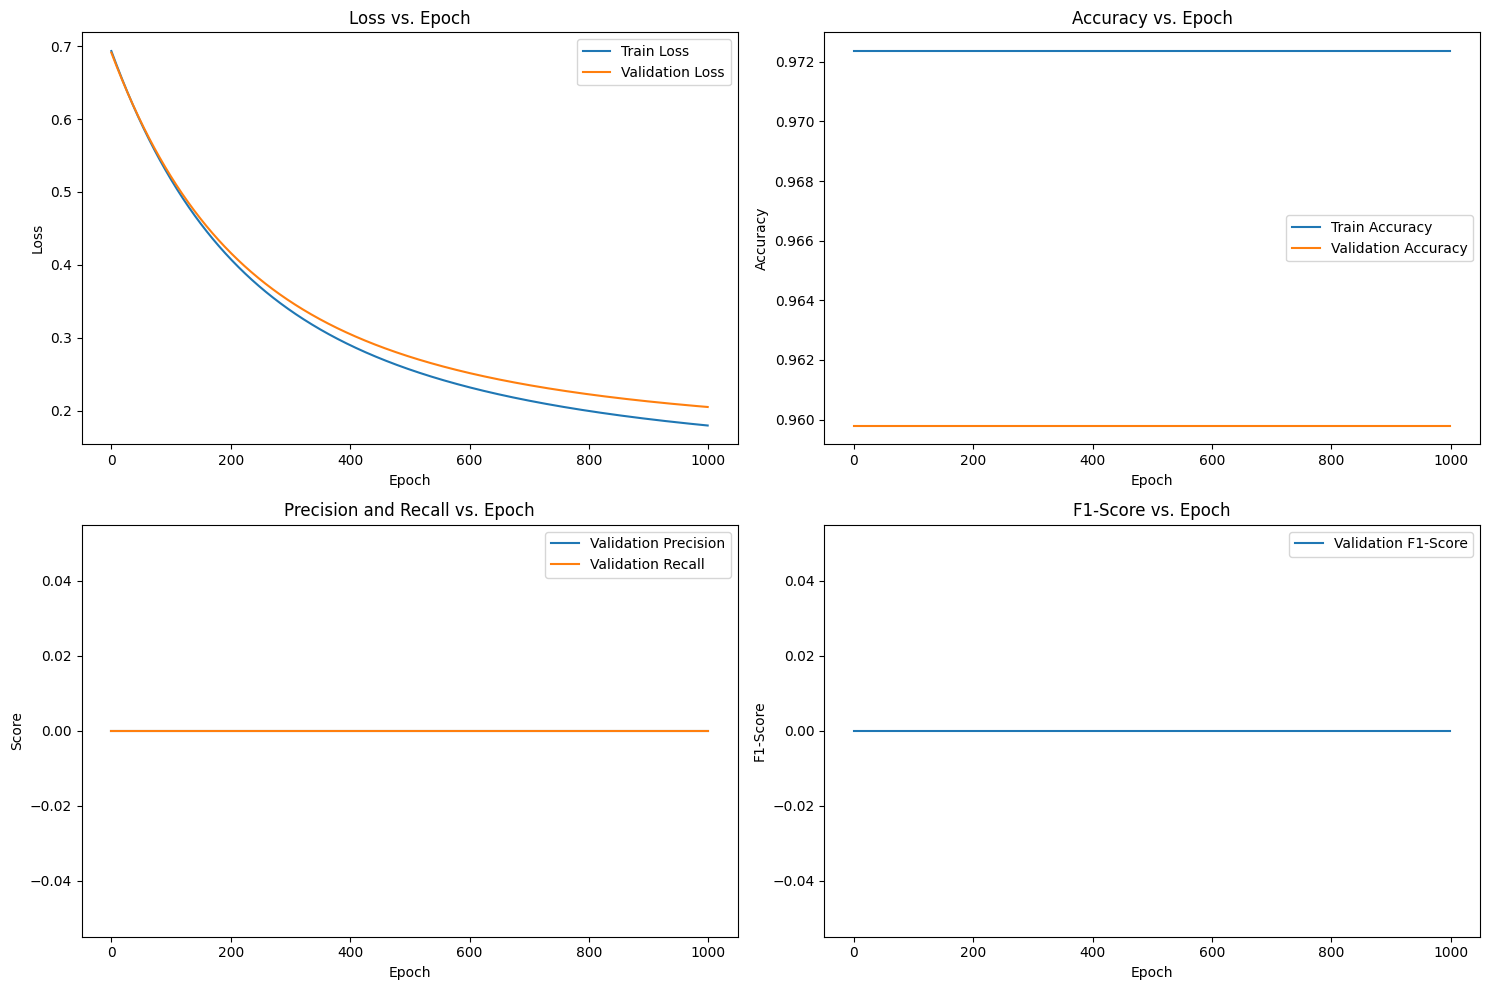

Final Test Accuracy: 0.9598
Final Test Precision: 0.0000
Final Test Recall: 0.0000
Final Test F1-Score: 0.0000


In [28]:
# Plot metrics
plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision and Recall plot
plt.subplot(2, 2, 3)
plt.plot(val_precisions, label='Validation Precision')
plt.plot(val_recalls, label='Validation Recall')
plt.title('Precision and Recall vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# F1-score plot
plt.subplot(2, 2, 4)
plt.plot(val_f1s, label='Validation F1-Score')
plt.title('F1-Score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
print(f"Final Test Accuracy: {val_accuracies[-1]:.4f}")
print(f"Final Test Precision: {val_precisions[-1]:.4f}")
print(f"Final Test Recall: {val_recalls[-1]:.4f}")
print(f"Final Test F1-Score: {val_f1s[-1]:.4f}")